In [1]:
import torch
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
from torch.nn import functional as F


In [2]:
model_pretrain = torch.load('serialnet_pretrain')
model_posttrain = torch.load('serialnet_trained')

(array([[ 5.,  5.,  7., ..., 10.,  3.,  8.],
        [ 8.,  6.,  7., ...,  6.,  7.,  6.],
        [ 4.,  5.,  4., ..., 13.,  8.,  8.],
        ...,
        [ 7., 13.,  7., ...,  4.,  5.,  5.],
        [ 5.,  7.,  6., ...,  4.,  7.,  5.],
        [ 7.,  7.,  7., ...,  9.,  5.,  9.]]),
 array([-5.10295406e-02, -4.08240631e-02, -3.06185838e-02, -2.04131044e-02,
        -1.02076260e-02, -2.14762986e-06,  1.02033308e-02,  2.04088092e-02,
         3.06142885e-02,  4.08197679e-02,  5.10252453e-02]),
 <a list of 384 BarContainer objects>)

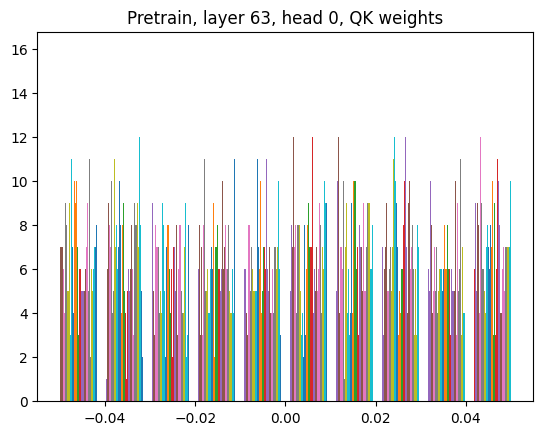

In [3]:
weights = model_pretrain.serial_nn[63].layer.layer.F.sa.heads[0].key.weight.cpu().detach().numpy()
plt.title('Pretrain, layer 63, head 0, QK weights')
plt.hist(weights)

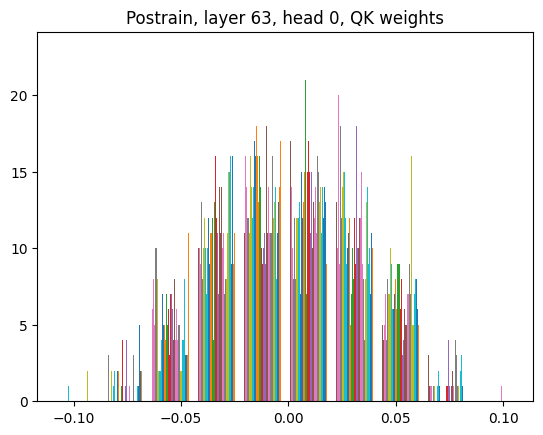

In [4]:
for i in [ 63]:
    weights = model_posttrain.serial_nn[i].layer.layer.F.sa.heads[0].key.weight.cpu().detach().numpy()
    # plt.title(f'Layer {i}')
    plt.title('Postrain, layer 63, head 0, QK weights')
    plt.hist(weights)
    plt.show()

I can print weights, how do I obtain trajectory for a the serial net? 

In [5]:
import os
import data
from torch.utils.data import Dataset, DataLoader


In [6]:
DATA_DIR = os.path.join('..', 'data')
train_data, val_data, decode, vocabulary_size = \
        data.obtain_data(DATA_DIR, 'wikipedia', 'gpt2', .2)

class TextDataset(Dataset):
    def __init__(self, data, context_window = 256):
        self.length = len(data) // context_window - 1

        self.data = data
        self.context_window = context_window

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data[idx * self.context_window:(idx + 1) * self.context_window], \
                self.data[1 + idx * self.context_window:1 + (idx + 1) * self.context_window]


train_dataset = TextDataset(train_data, 256)
train_loader  = DataLoader(train_dataset, batch_size=10, shuffle=False, drop_last=True)


Loaded tensor from ../data/wikipedia.data
1.4 Splitting data into training and validation data
len(train_data)=104035585, len(val_data)=11559510 percent_data=0.2
len(train_data)=20807117, len(val_data)=2311902


In [7]:
model_posttrain = model_posttrain.to('cuda')
model_pretrain = model_pretrain.to('cuda')

In [12]:
first_index = []
model = model_posttrain 
for idx, (data, target) in enumerate(train_loader):
    data, target = data.to('cuda'), target.to('cuda')
    
    # Expand layer1 one by one...
    open = model.open_nn(data)

    # Middle chunk 
    # layers = model.serial_nn(open)
    # print(layers.flatten()[0]) # Expect -73.1935

    layers = open
    for i in range(64):
        layers = model.serial_nn[i](layers)

        first_index.append(layers.flatten()[5].cpu().detach().numpy())
    # print(layers.flatten()[0]) # Expect -73.1935
    
    # output 
    out = model.close_nn(layers)
    B, T, C = out.shape
    out = out.view(B*T, C)
    target = target.view(B*T)

    # print(F.cross_entropy(out, target))
    break

Text(0.5, 0, 'Number of layers')

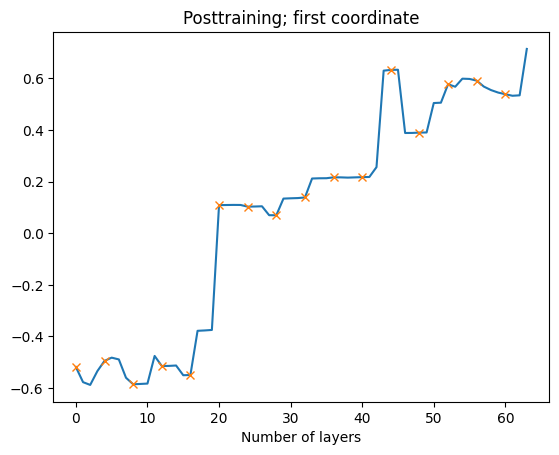

In [13]:
plt.title('Posttraining; first coordinate')
plt.plot(first_index, '-')
plt.plot(np.arange(0, 64, 4), first_index[::4], 'x')
plt.xlabel('Number of layers')


In [30]:
reg_value = 0
for i in range(64 - 1):
    # Loop over ** all ** weights
    # for param_name, weights_n in model.parallel_nn.local_layers[i].named_parameters():
    for param_name, weights_n in model.serial_nn[i].named_parameters():
        # Grab weight from next layer 
        weights_np1 = model.serial_nn[i + 1].state_dict()[param_name]
        # print(weights_np1)
        # Calculate norm
        reg_value += torch.norm(weights_n - weights_np1, p='fro') ** 2

print(reg_value)
    

tensor(129027.5078, device='cuda:0', grad_fn=<AddBackward0>)


In [23]:
for i in model.serial_nn[0].named_parameters():
    print(i[0])

layer.layer.F.sa.heads.0.key.weight
layer.layer.F.sa.heads.0.query.weight
layer.layer.F.sa.heads.0.value.weight
layer.layer.F.sa.heads.1.key.weight
layer.layer.F.sa.heads.1.query.weight
layer.layer.F.sa.heads.1.value.weight
layer.layer.F.sa.heads.2.key.weight
layer.layer.F.sa.heads.2.query.weight
layer.layer.F.sa.heads.2.value.weight
layer.layer.F.sa.heads.3.key.weight
layer.layer.F.sa.heads.3.query.weight
layer.layer.F.sa.heads.3.value.weight
layer.layer.F.sa.heads.4.key.weight
layer.layer.F.sa.heads.4.query.weight
layer.layer.F.sa.heads.4.value.weight
layer.layer.F.sa.heads.5.key.weight
layer.layer.F.sa.heads.5.query.weight
layer.layer.F.sa.heads.5.value.weight
layer.layer.F.sa.proj.weight
layer.layer.F.sa.proj.bias
layer.layer.F.ffwd.net.0.weight
layer.layer.F.ffwd.net.0.bias
layer.layer.F.ffwd.net.2.weight
layer.layer.F.ffwd.net.2.bias
layer.layer.F.ln1.weight
layer.layer.F.ln1.bias
layer.layer.F.ln2.weight
layer.layer.F.ln2.bias
